# Spectral species testing

By Tim Hackwood, for SPA 556 24.08.2024.

This Notebook demonstrates techniques for creating spectral species over the Brigalow Belt bioregion in Queensland, Australia.

Spectral species concept from Asner 2014

Methodology for python segmentation adapted from Peter Scarth (2022) https://github.com/petescarth/segmentation-example, with pyshepseg https://github.com/ubarsc/pyshepseg

Need gdal version 3.9.1

In [15]:
# Imports
from rios import applier, cuiprogress
import pickle
import geopandas as gpd
from tqdm import tqdm
import shapely
from shapely import box
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np
import os
import galah
from osgeo import gdal, ogr, gdalconst, osr
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import joblib
from rios import rat
from rios import applier, cuiprogress, pixelgrid
from rios import ratapplier
from pyshepseg import tiling
from pyshepseg import tilingstats
from pyshepseg import utils
from pystac_client import Client
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import folium
from skimage import exposure
import pandas as pd
import shapely.geometry

# Set the working directory to SpectralBotany
os.chdir("/home/tim/rubella/scripts/SpectralBotany")

# Config for Atlas Living Australia APO
galah.galah_config(email = "timothy.hackwood@gmail.com", atlas = "Australia")

AOI = "data/SpectralBotanyTest.gpkg"
Layer = "BrigalowBeltAOI"

# FIles for PCA and Segment outputs
RASTER_PC = "data/Landsat/LandsatBarest_brigalow_PCA_250m.tif" # 250m version for demonstration purposes
RASTER_SEG = RASTER_PC.replace(".tif", "_segs.kea")

In [ ]:
# Load AOI
brigalow = gpd.read_file(AOI, layer=Layer)
# Reproject to WGS84 for STAC API
brigalow.to_crs(4326, inplace=True)
# Plot to check everything looks ok
brigalow.plot()

## Plotting function

In [3]:
def plot_rgb_to_html(input_tif, output_html, zoom=8, nodata=0, bandorder=[1, 2, 3]):
    """
    Warp tif to wgs84, normalize data and stretch autimatically, and create a folium map with the raster overlay 
    """
    # Virtually warp to wgs84
    PCA_web = input_tif.replace(".tif", "_4326.tif")

    # Define the target CRS as EPSG:4326 (WGS 84)
    target_crs = 'EPSG:4326'

    # Reproject the raster in memory
    gdal.Warp(PCA_web, input_tif, dstSRS=target_crs, format='GTiff')

    # Open the reprojected raster file with rasterio
    with rasterio.open(PCA_web) as src:
        # Read the first three bands
        data = src.read(bandorder).astype(np.float32)
        
        # Identify the no-data values (assuming 0 is no-data; adjust if needed)
        no_data_mask = np.all(data == nodata, axis=0)

        # Normalize data to [0, 1] for each band before applying CLAHE
        data_normalized = np.array([exposure.rescale_intensity(band, in_range=(band.min(), band.max()), out_range=(0, 1)) for band in data])

        # Apply adaptive histogram equalization (CLAHE) for better contrast
        data_equalized = np.array([exposure.equalize_adapthist(band, clip_limit=0.03) for band in data_normalized])
        
        # Reshape data for plotting
        data = reshape_as_image(data_equalized)

        # Add alpha channel: 0 where no-data, 1 elsewhere
        alpha_channel = np.where(no_data_mask, 0, 1).astype(np.uint8)
        data = np.dstack((data, alpha_channel))

        # Get bounds of the raster
        bounds = src.bounds
        top_left = [bounds.top, bounds.left]
        bottom_right = [bounds.bottom, bounds.right]

    # Create a base map
    m = folium.Map(location=[(top_left[0] + bottom_right[0]) / 2,
                             (top_left[1] + bottom_right[1]) / 2],
                   zoom_start=zoom)

    # Add the raster image as an overlay
    raster_layer = folium.raster_layers.ImageOverlay(
        image=data,
        bounds=[[bottom_right[0], top_left[1]], [top_left[0], bottom_right[1]]],
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1
    )
    raster_layer.add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

    # Save map to HTML file
    m.save(output_html)

## Get Landsat data if needed

In [18]:
# Function to build vrt by band from DEA files on STAC API for each band
def buildVRT(tiles, dir):

    # List of the band names to stack in the VRT
    BandNames = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
    
    vrtList = []

    # Make a full timeseries vrt with each band
    for band in BandNames:
        vrtName = band + '_.vrt'
        vrt = os.path.join(dir, vrtName)
        vrtList.append(vrt)
        urlList = []
        for item in tiles:
            # Get the url for the band
            url = item.assets[band].href
            # Add it to the list
            urlList.append(url.replace(
                's3://',
                '/vsis3/'))
        # Set options for the VRT file
        vrtOptions = gdal.BuildVRTOptions(resampleAlg='nearest',
                                        separate=False,
                                        resolution='highest',
                                        VRTNodata=-999)

        # Then make the VRT file using the list of URLs
        vrtData = gdal.BuildVRT(vrt,
                                urlList,
                                options=vrtOptions)
        
        # Close the VRT file
        vrtData = None

    return vrtList

In [20]:
# Get landsat-8 data (using DEA barest-earth)
brigalow.to_crs(4326, inplace=True)
bbox = brigalow.total_bounds

# STAC querey
client = Client.open("https://explorer.sandbox.dea.ga.gov.au/stac")
s2Search = client.search(
    bbox=bbox,
    collections=['ls8_barest_earth_albers'],
)
# Show the results of the search
print(f"{s2Search.matched()} items found")

tiles = s2Search.item_collection()

# Build the virtual mosaic for each band
print("Building virtual band mosaics")
vrtList = buildVRT(tiles, 'data/Landsat')

vrtOptions = gdal.BuildVRTOptions(resampleAlg='nearest',
                                separate=True,
                                resolution='highest',
                                VRTNodata=-999)
print("Stacking bands")
vrtData = gdal.BuildVRT('data/Landsat/LandsatBarest_brigalow.vrt',
                        vrtList,
                        options=vrtOptions)

# Close the VRT file
vrtData = None


61 items found
Building virtual band mosaics
Stacking bands


In [16]:
# Make a 250m resampled image for this demonstration
Landsat = "data/Landsat/LandsatBarest_brigalow.vrt".replace(".vrt", "_250m.tif")
gdal.Warp(Landsat, "data/Landsat/LandsatBarest_brigalow.vrt", xRes=250, yRes=250, resampleAlg="nearest", format='GTiff')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x702b119a76f0> >

In [21]:
# Export landsat to a web map
plot_rgb_to_html(Landsat, "LandsatBarest_brigalow.html", zoom=8, nodata=-999, bandorder=[3, 2, 1])

## Stack with indices and get PCA for segmentation

In [24]:
# Make a subsampled dataset of multispectral imagery for PCA
with rasterio.open("data/Landsat/LandsatBarest_brigalow.vrt") as src:
    # Calculate the bounding box of brigalow (Landsat imagery is in Albers)
    brigalow.to_crs(epsg=3577, inplace=True)
    bbox = brigalow.total_bounds
    # Open a subsampled version of the image
    out_height = int(src.height / 100)
    out_width = int(src.width / 100)

    # Read the subsampled data from src using the bounding box
    img = src.read(window=rasterio.windows.from_bounds(*bbox, transform=src.transform), out_shape=(src.count, out_height, out_width))
    inshape = img.shape
    print(inshape)

(6, 360, 320)


In [25]:
# Get indicies and fit the PCA

N_COMPONENTS = 3 # Change depending on variance.

# Calculate NDVI/NDWI, stack and scale
# Landsat-8 bands - TERN Sentinel 2 seasonal surface reflectance is the same as landsat 8
ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])

    
# Stack these ratios with the original data
stack = np.vstack([img, ndvi, ndwi])
print(stack.shape)

# Reshape stack for scaling
scale = np.reshape(stack, (stack.shape[0], -1))

# Delete unneeded variables
del img
del ndvi
del ndwi

# Rescale with robust scaler    
scaler = RobustScaler()
stack_scale = scaler.fit_transform(scale.T)
# Save the scaler
joblib.dump(scaler, './stack_scaler.pkl')
print(stack_scale.shape)

del scale

# Fit the PCA
pca = PCA(n_components=N_COMPONENTS, svd_solver='full', whiten=True)
pca.fit(stack_scale)
# Print the variance and save the PCA
sumvar = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained: {sumvar}")
joblib.dump(pca, './pca.pkl')

# Transform the data to byte scale and save
pcaData = pca.transform(stack_scale).T
byteScale = np.percentile(pcaData,[0.001,99.999],axis=1)
joblib.dump(byteScale, './byteScale.pkl')

(8, 360, 320)
(115200, 8)
Variance explained: [0.68874098 0.92615735 0.98316599]


['./byteScale.pkl']

In [3]:
# Apply the PCA to the full image and mask to Brigalow AOI
# Takes ~20 minutes
def _applyPCA(info, inputs, outputs, otherargs):
    """
    Apply PCA to full resolution dataset.
    """
    # Open the images
    img = inputs.raster
    inshape = img.shape
    aoi = inputs.aoi
    
    # Get indicies
    ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
    ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])

        
    # Stack these ratios with the original data
    stack = np.vstack([img, ndvi, ndwi])
    scaled_stack = np.reshape(stack, (stack.shape[0], -1)).astype('float32').T

    # Apply the PCA    
    pc = otherargs.pca.transform(otherargs.scaler.transform(scaled_stack))
    # Rescale to 16bit
    pc = np.round(np.clip(1.0 + 65534.0
                        * (pc-otherargs.bytescale[0])
                        / (otherargs.bytescale[1]-otherargs.bytescale[0])
                        ,1,65535))
        
    # Reshape the output
    pc = np.reshape(pc.T,(pc.shape[1],inshape[1],inshape[2]))
    # Mask the output for no data

    pc[:,np.any(stack == otherargs.noData,axis=0)] = 0
    pc[:, np.any(aoi == 0, axis=0)] = 0 # mask to the AOI
    outputs.pc =  pc.astype(np.uint16)

# Get the no data value
ds = gdal.Open("data/Landsat/LandsatBarest_brigalow.vrt")
noData = ds.GetRasterBand(1).GetNoDataValue()
    
# Create the RIOS file objects
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()

# Setup the IO
infiles.raster = "data/Landsat/LandsatBarest_brigalow.vrt"
infiles.aoi = "data/SectralBotanyTest.gpkg"

outfiles.pc = RASTER_PC

# Get the otherargs
otherargs = applier.OtherInputs()
otherargs.pca = joblib.load("pca.pkl")
otherargs.scaler = joblib.load("stack_scaler.pkl")
otherargs.bytescale = joblib.load("byteScale.pkl")
otherargs.noData = noData

# Controls for the processing   
controls = applier.ApplierControls()
controls.vectorlayer = "BrigalowBeltAOI"
controls.setBurnValue = 1
controls.windowxsize = 512
controls.windowysize = 512
controls.setStatsIgnore(0) #  nodata
controls.progress = cuiprogress.CUIProgressBar()
controls.setFootprintType("INTERSECTION")
controls.setResampleMethod("near")
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions(["COMPRESS=DEFLATE",
                                "ZLEVEL=9",
                                "PREDICTOR=2",
                                "BIGTIFF=YES",
                                "TILED=YES",
                                "INTERLEAVE=BAND",
                                "NUM_THREADS=ALL_CPUS",
                                "BLOCKXSIZE=512",
                                "BLOCKYSIZE=512"])

# Set concurrency depending on system
conc = applier.ConcurrencyStyle(numReadWorkers=3,
                                numComputeWorkers=2,
                                computeWorkerKind="CW_THREADS",
                                readBufferPopTimeout=120,
                                computeBufferPopTimeout=120
                                )

controls.setConcurrencyStyle(conc)

# Run the function
print("Processing PCA")
applier.apply(_applyPCA, infiles, outfiles, otherargs, controls=controls)   


Computing Pyramid Layers...

Computing Statistics...


In [2]:
# Make a 250m resampled image for this demonstration
PCA_250m = RASTER_PC.replace(".tif", "_250m.tif")
gdal.Warp(PCA_250m, RASTER_PC, xRes=250, yRes=250, resampleAlg="nearest", format='GTiff')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x749fc1e4a6d0> >

In [ ]:
# plot the result to a slippy map
plot_rgb_to_html(PCA_250m, "PCA_250m.html", zoom=8)


## Segment the PCA to get Spectral Species equivalent

In [5]:
SEGMENT_SIZE = 4 # Approximately 25 hectare minimum segment size @ 250m
N_COMPONENTS = 3 # Number of PCA components

# Segment using the tiled version
print('Segmenting')
tiledSegResult = tiling.doTiledShepherdSegmentation(RASTER_PC, RASTER_SEG,
            minSegmentSize=SEGMENT_SIZE, numClusters=512,
            bandNumbers=None, subsamplePcnt=None,
            maxSpectralDiff='auto', spectDistPcntile=25,
            imgNullVal=0, fourConnected=True, verbose=True,
            simpleTileRecode=False, outputDriver='KEA', kmeansObj=None)
           
# Do histogram, stats and colour table on final output file.
print('Adding Histogram, Stats and Colour Table')
outDs = gdal.Open(RASTER_SEG, gdal.GA_Update)
hist = tiling.calcHistogramTiled(outDs, tiledSegResult.maxSegId, writeToRat=True)
band = outDs.GetRasterBand(1)
utils.estimateStatsFromHisto(band, hist)
utils.writeRandomColourTable(band, tiledSegResult.maxSegId+1)
del outDs

# Add the original Image Stats
print('Adding Image Stats')
for imgbandnum in range(1,N_COMPONENTS+1):
    statsSelection = [
        ('pca_Band_{}_mean'.format(imgbandnum), 'mean'),
        ('pca_Band_{}_std'.format(imgbandnum), 'stddev')]
    tilingstats.calcPerSegmentStatsTiled(RASTER_PC, imgbandnum, RASTER_SEG,statsSelection)

# Export the segmentation as tifs for visualisation
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.id = RASTER_SEG.replace('.kea', '_id.tif')
outfiles.rgb = RASTER_SEG.replace('.kea', '_rgb.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
for i in range(1, N_COMPONENTS+1):
    setattr(otherargs, f'b{i}', 
            np.round(rat.readColumn(infiles.image, f'pca_Band_{i}_mean')).astype(np.uint16))

otherargs.noData = 0
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512  # Set both attributes on the same line
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(0)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = np.vstack([getattr(otherargs, f'b{i}')[data] for i in range(1, N_COMPONENTS+1)])
    outputs.id = data.reshape((1,) + inputs.image.shape[1:]).astype(np.uint32)
    outputs.rgb = rgb.reshape((rgb.shape[0],) + inputs.image.shape[1:]).astype(np.uint16)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Segmenting
Starting tiled segmentation
KMeans of whole raster 100.71 seconds
Subsample Percentage=8.68
Found 1 tiles, with 1 rows and 1 cols

Doing tile 1 of 1: row=0, col=0
Kmeans, in 2.6 seconds
Found 2564511 clumps, in 0.4 seconds
Eliminated 2097568 single pixels, in 1.0 seconds
Eliminated 67693 segments, in 2.6 seconds
Final result has 399250 segments
Stitching tiles together
Stitching tile row 0
Adding Histogram, Stats and Colour Table
Adding Image Stats
Exporting Segmentation


In [9]:
# Plot the RGB segmentation to inspect the segments
plot_rgb_to_html(RASTER_SEG.replace('.kea', '_rgb.tif'), "segmentationRGB.html", zoom=8)

Finding optimal number of clusters:   0%|          | 0/246 [00:00<?, ?it/s]

Finding optimal number of clusters: 100%|██████████| 246/246 [00:22<00:00, 11.08it/s]

Top 5 number of classes: [240 168 224 222  10]


Text(0.5, 0, 'Number of clusters')

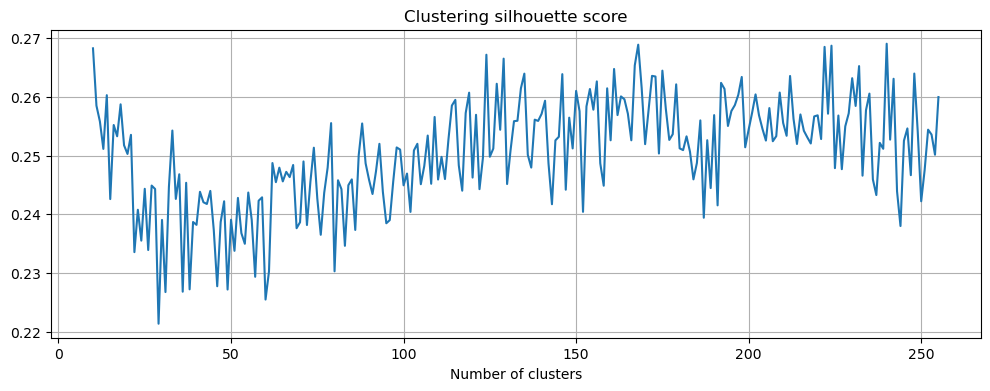

In [10]:
# Use K-means to cluster the segments. This would be a categorical predictor for a SDM

wantedAttributes = ['pca_Band_1_mean', 'pca_Band_2_mean', 'pca_Band_3_mean']

# Read the data into an array
clusterData  = np.transpose([rat.readColumn(RASTER_SEG,name) for name in wantedAttributes])

# Drop the first row, as it contains the nodata
clusterData = clusterData[1:]

# Scale the data
clusterData = RobustScaler().fit_transform(clusterData)

# Sample the data to reduce the number of points
MAX_TESTING_POINTS = 1000
sampleSize = min(MAX_TESTING_POINTS,clusterData.shape[0])
sampleIdx = np.random.choice(clusterData.shape[0],sampleSize,replace=False)


# Find the optimal number of clusters
inertia = []
silhouette = []
nclasses = range(10,256)
for c in tqdm(nclasses, desc='Finding optimal number of clusters'):
    kmeans = MiniBatchKMeans(n_clusters=c).fit(clusterData[sampleIdx])
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(clusterData[sampleIdx], kmeans.labels_))

# Find top 5 number of classes and silhouette score
top5 = np.argsort(silhouette)[::-1][:5]
print(f"Top 5 number of classes: {np.array(nclasses)[top5]}")

# Plot the silhouette score
plt.figure(figsize=(12,4))
plt.plot(nclasses, silhouette)
plt.grid()
plt.title('Clustering silhouette score')
plt.xlabel('Number of clusters')

In [11]:
# Cluster the data using K-means and write to a csv with other Segment columns
OPTIMAL_NUM_CLUSTERS = 240
# Cluster the full dataset
kmeans = MiniBatchKMeans(n_clusters = OPTIMAL_NUM_CLUSTERS).fit(clusterData)
# Get the cluster labels and add one to avoid zero values
clusterLabels = kmeans.labels_ + 1
# Add back in the first row of nodata
clusterLabels = np.insert(clusterLabels,0,0)

# Write to .csv
# Get the column names
colNames = rat.getColumnNames(RASTER_SEG)
# Read the data into an array
allData = np.transpose([rat.readColumn(RASTER_SEG, name) for name in colNames])
# Add an index column
allData = np.vstack((np.arange(len(allData)),allData.T)).T
# Add the kmeans labels
allData = np.vstack((allData.T,clusterLabels)).T
# Make a header
colNames.insert(0,'segid')
colNames.append('kmeans_label')
header = ','.join(colNames)
# Write the file
np.savetxt(RASTER_SEG.replace(".kea", ".csv"),allData,fmt='%8.3f',delimiter=',',header=header,comments='')

In [4]:
# Write the segmentation to Geopackage
outDs = gdal.Open(RASTER_SEG.replace(".kea", "_id.tif"))
band = outDs.GetRasterBand(1) # Band 1 is the segment ids
# Open the existing vector datasource
vecDs = ogr.Open(AOI, 1)  # 1 means it's opened in update mode
# Create a new layer in the existing geopackage
vecLayer = vecDs.CreateLayer('BrigalowSegID', srs=osr.SpatialReference(wkt=outDs.GetProjection()))
vecLayer.CreateField(ogr.FieldDefn('segid', ogr.OFTInteger))
# Polygonize
vecDs.StartTransaction()
gdal.Polygonize(band, None, vecLayer, 0, [], callback=None)
vecDs.CommitTransaction()

del outDs
del vecDs

In [57]:
# Join segments to attributes .csv
Segs = gpd.read_file(AOI, layer='BrigalowSegID')
attributes = gpd.read_file(RASTER_SEG.replace(".kea", ".csv"))

# Join on segid
attributes['segid'] = attributes['segid'].astype(float).astype(int)
attributes['kmeans_label'] = attributes['kmeans_label'].astype(float).astype(int)
Segs = Segs.merge(attributes, on='segid')
Segs


,segid,geometry,Histogram,Blue,Green,Red,Alpha,pca_Band_1_mean,pca_Band_1_std,pca_Band_2_mean,pca_Band_2_std,pca_Band_3_mean,pca_Band_3_std,kmeans_label
0,1,"POLYGON ((1792750 -2576000, 1792750 -2576250, ...",5.000,121.000,243.000,114.000,255.000,10915.200,2417.177,37858.602,1212.091,35504.199,2665.090,91
1,4,"POLYGON ((1793500 -2576250, 1793500 -2577000, ...",4.000,233.000,194.000,235.000,255.000,9813.750,1711.167,36586.250,1630.306,38107.000,1938.656,229
2,2,"POLYGON ((1792250 -2576250, 1792250 -2576750, ...",11.000,131.000,115.000,210.000,255.000,9898.637,570.597,36949.727,713.999,34585.273,627.788,117
3,7,"POLYGON ((1791750 -2576500, 1791750 -2577250, ...",14.000,52.000,137.000,139.000,255.000,10562.071,422.534,38113.000,1088.757,34413.570,459.516,124
4,3,"POLYGON ((1793250 -2576250, 1793250 -2576500, ...",6.000,32.000,91.000,238.000,255.000,8996.000,1321.396,36347.168,1563.251,35769.168,909.526,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399317,399232,"POLYGON ((1835500 -3270000, 1835500 -3270250, ...",4.000,146.000,225.000,192.000,255.000,10096.000,775.085,36507.000,852.483,36157.500,433.812,40
399318,399231,"POLYGON ((1831000 -3270000, 1831000 -3270250, ...",6.000,151.000,92.000,42.000,255.000,9556.000,575.344,36280.000,417.339,35097.168,1035.049,117
399319,399234,"POLYGON ((1830250 -3270000, 1830250 -3270250, ...",5.000,17.000,202.000,103.000,255.000,9471.200,1209.144,35053.398,1228.107,36450.000,709.094,128
399320,399235,"POLYGON ((1835250 -3270500, 1835250 -3270750, ...",7.000,113.000,182.000,209.000,255.000,9106.429,421.836,36501.000,737.058,33950.430,1252.020,117


## Get an example species and test Species Distribution Modelling on the Spectral Species

In [11]:
# Get species data from ALA API
# Use the bbox from the AOI to get the occurrences

bbox = box(*brigalow.total_bounds)

# Coords need to be in 4283/4326

brigalow_occ = galah.atlas_occurrences(bbox = bbox, 
                                    taxa=['plantae'],
                                    filters=["year>=2014"],
                                    fields=["decimalLatitude",
                                            "decimalLongitude",
                                            "eventDate", 
                                            "scientificName",
                                            "vernacularName",
                                            "coordinateUncertaintyInMeters"])
# Make a geodataframe from the lat and longs
brigalow_occ = gpd.GeoDataFrame(
    brigalow_occ, 
    geometry=gpd.points_from_xy(brigalow_occ.decimalLongitude, brigalow_occ.decimalLatitude),
    crs="EPSG:4326"
)

brigalow_occ.to_crs(3577, inplace=True)

In [68]:
# Make a dataframe with presence data and join to Segment data
# Filter the DataFrame for "Casuarina cristata"
filtered_gdf = brigalow_occ[brigalow_occ['scientificName'].str.contains("Casuarina cristata")].copy()

# Replace spaces with underscores in species names
filtered_gdf.loc[:, 'species_name'] = filtered_gdf['scientificName'].str.replace(" ", "_")

# Set presence to 1
filtered_gdf.loc[:, 'presence'] = 1

# Drop unneeded columns
filtered_gdf.drop(columns=['decimalLatitude', 'decimalLongitude', 'eventDate', 'scientificName', 'vernacularName'], inplace=True)

# Intersect with segments
Segs_intersected = gpd.overlay(Segs, filtered_gdf, how='intersection', keep_geom_type=False)

Segs.loc[Segs['segid'].isin(Segs_intersected['segid']), 'presence'] = 1

In [75]:
# Generate pseudoabsences

Absence_ratio = 5

Segs_presence = Segs.copy()

Segs_presence = Segs_presence[Segs_presence['segid'] != 0]

# Get number of presences
num_presence = len(Segs_presence[Segs_presence['presence'] == 1])

# Randomly select rows by segid
random_rows = Segs_presence.sample(n=num_presence*Absence_ratio, random_state=42)

# Set these segments to absent '0'
Segs_presence.loc[Segs_presence['segid'].isin(random_rows['segid']), 'presence'] = 0

# Print number of presences and absences in the dataset
num_presence = len(Segs_presence[Segs_presence['presence'] == 1])
num_absence = len(Segs_presence[Segs_presence['presence'] == 0])
print("Number of presences:", num_presence)
print("Number of absences:", num_absence)


Number of presences: 53
Number of absences: 265


In [76]:
# Save to project geopackage
Segs_presence.to_file(AOI, layer="Casuarina_cristata", driver="GPKG")

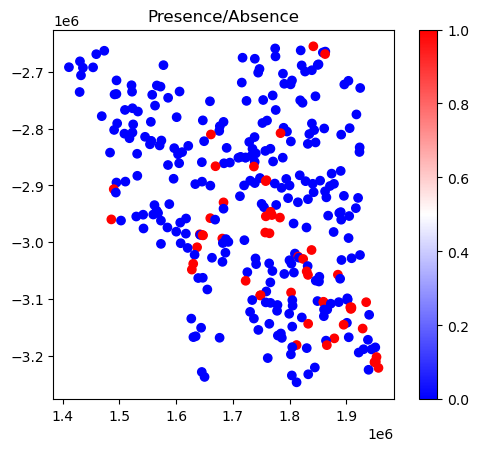

In [77]:
# Plot the data

# Make points from centroid of polygon
Segs_presence['centroid'] = Segs_presence.centroid
points = Segs_presence.copy()
points.set_geometry('centroid', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the presence column with a red/blue colormap
points.plot(column='presence', cmap='bwr', ax=ax, legend=True)

# Set the title and axis labels
ax.set_title('Presence/Absence')

# Show the plot
plt.show()